In [1]:
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
import keras.applications.resnet
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from google.colab import drive
train_dir = "/content/drive/MyDrive/DataSetASD/training_set"
eval_dir = "/content/drive/MyDrive/DataSetASD/test_set"

In [2]:
import keras
from google.colab import drive
import os
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  40
Number of training images:  3200
Number of testing images:  800
Number of evaluation images:  2150


In [4]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_eval = tf.keras.utils.to_categorical(y_eval)

In [5]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
40


In [6]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [7]:
#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [8]:
#Initialising resnet50 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
classifier_resnet = ResNet50(input_shape=(64,64,3),include_top=False,weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [10]:
#VGG16
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=40, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#resnet50
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=40, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#summary of vgg16
model.summary()

#summary of resnet50
model2.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [11]:
#fit the model
#vgg16
history = model.fit(X_train, y_train, epochs =5, batch_size = 32,validation_data=(X_test,y_test))


Epoch 1/5
100/100 [==============================] - 167s 2s/step - loss: 1.6049 - accuracy: 0.6228 - val_loss: 0.1918 - val_accuracy: 1.0000
Epoch 2/5
100/100 [==============================] - 166s 2s/step - loss: 0.2547 - accuracy: 0.9747 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 3/5
100/100 [==============================] - 165s 2s/step - loss: 0.1003 - accuracy: 0.9916 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 4/5
100/100 [==============================] - 165s 2s/step - loss: 0.0593 - accuracy: 0.9966 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 5/5
100/100 [==============================] - 166s 2s/step - loss: 0.0417 - accuracy: 0.9966 - val_loss: 0.0023 - val_accuracy: 1.0000


In [12]:
#fit the model
#resnet50
history2 = model2.fit(X_train, y_train, epochs =5, batch_size = 32,validation_data=(X_test,y_test))

Epoch 1/5
100/100 [==============================] - 60s 571ms/step - loss: 1.7624 - accuracy: 0.5941 - val_loss: 0.4253 - val_accuracy: 1.0000
Epoch 2/5
100/100 [==============================] - 56s 561ms/step - loss: 0.3737 - accuracy: 0.9681 - val_loss: 0.1445 - val_accuracy: 1.0000
Epoch 3/5
100/100 [==============================] - 56s 561ms/step - loss: 0.1867 - accuracy: 0.9922 - val_loss: 0.0746 - val_accuracy: 1.0000
Epoch 4/5
100/100 [==============================] - 57s 568ms/step - loss: 0.1136 - accuracy: 0.9953 - val_loss: 0.0454 - val_accuracy: 1.0000
Epoch 5/5
100/100 [==============================] - 56s 559ms/step - loss: 0.0822 - accuracy: 0.9969 - val_loss: 0.0307 - val_accuracy: 1.0000


In [13]:
# Saving the model of vgg16
model.save('model_vgg16.h5')
# Saving the model of resnet
model2.save('model_resnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %
Accuracy for evaluation images: 96.837 %


In [15]:
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %
Accuracy for evaluation images: 86.233 %


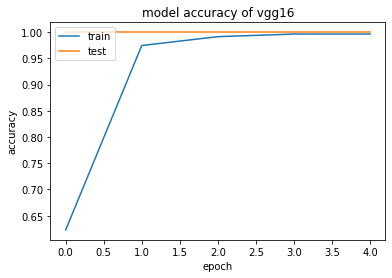

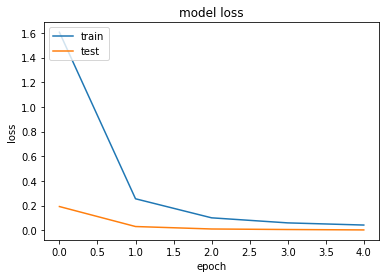

In [16]:
#vgg16
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

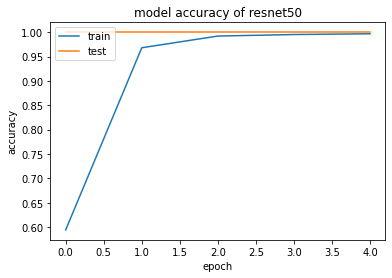

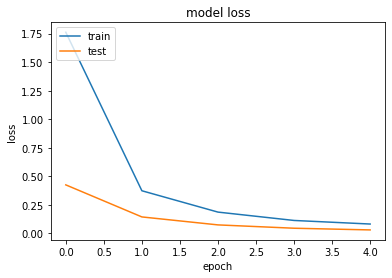

In [17]:
#resnet50
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy of resnet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

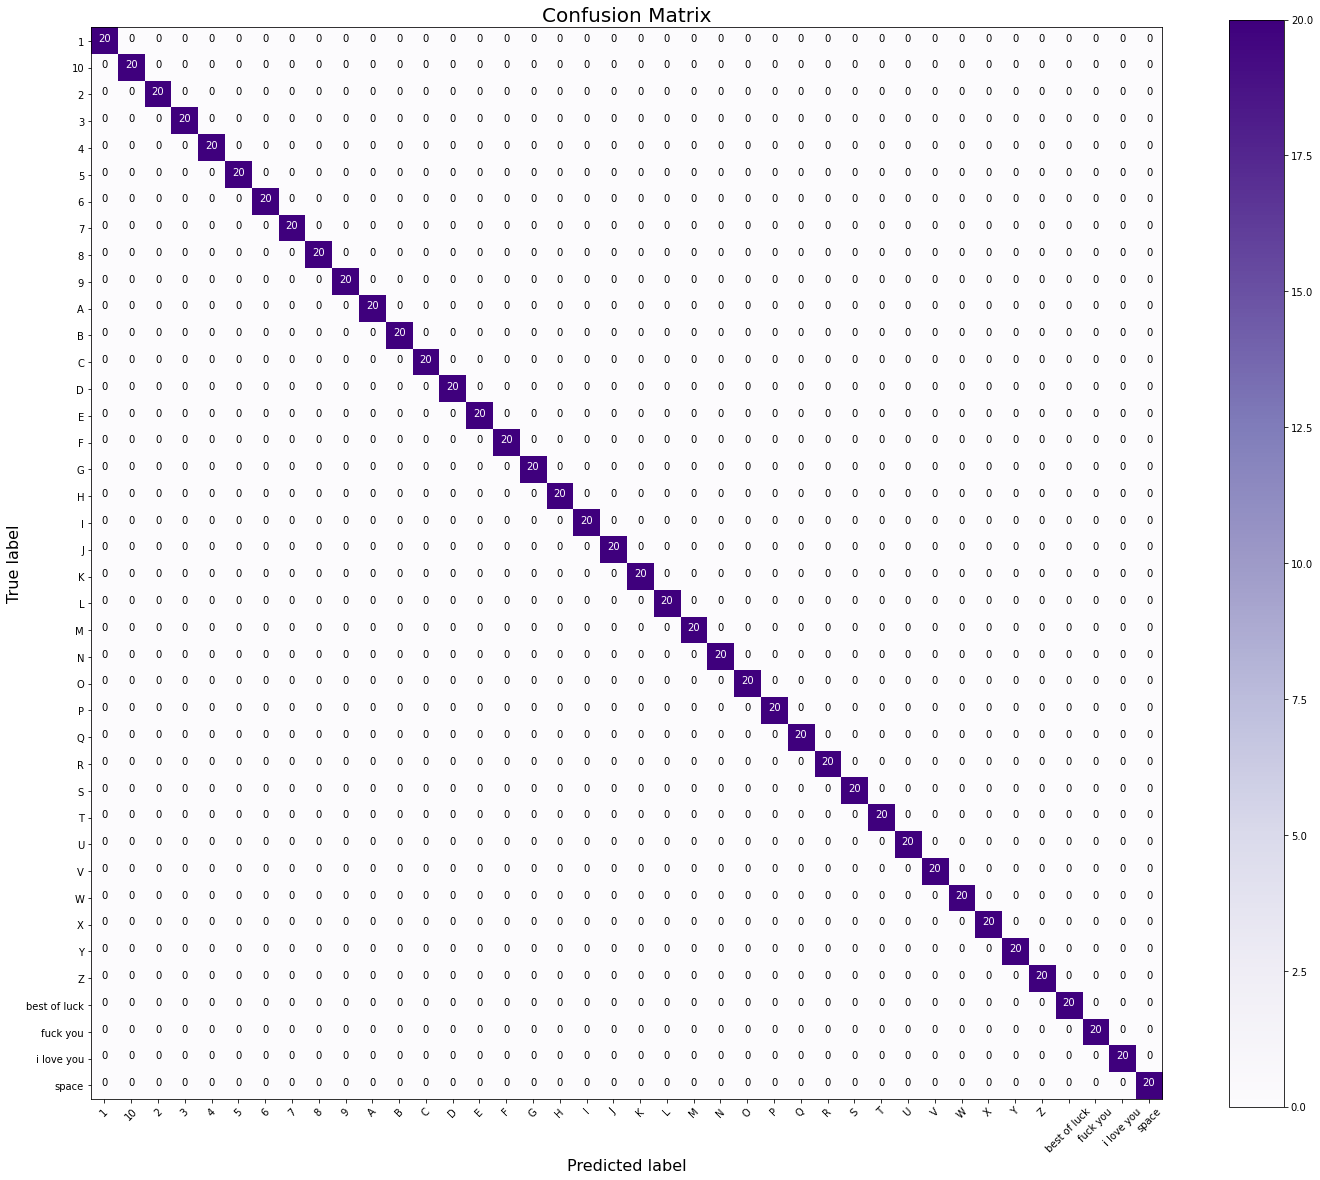

In [18]:
#Helper function to plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()
y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

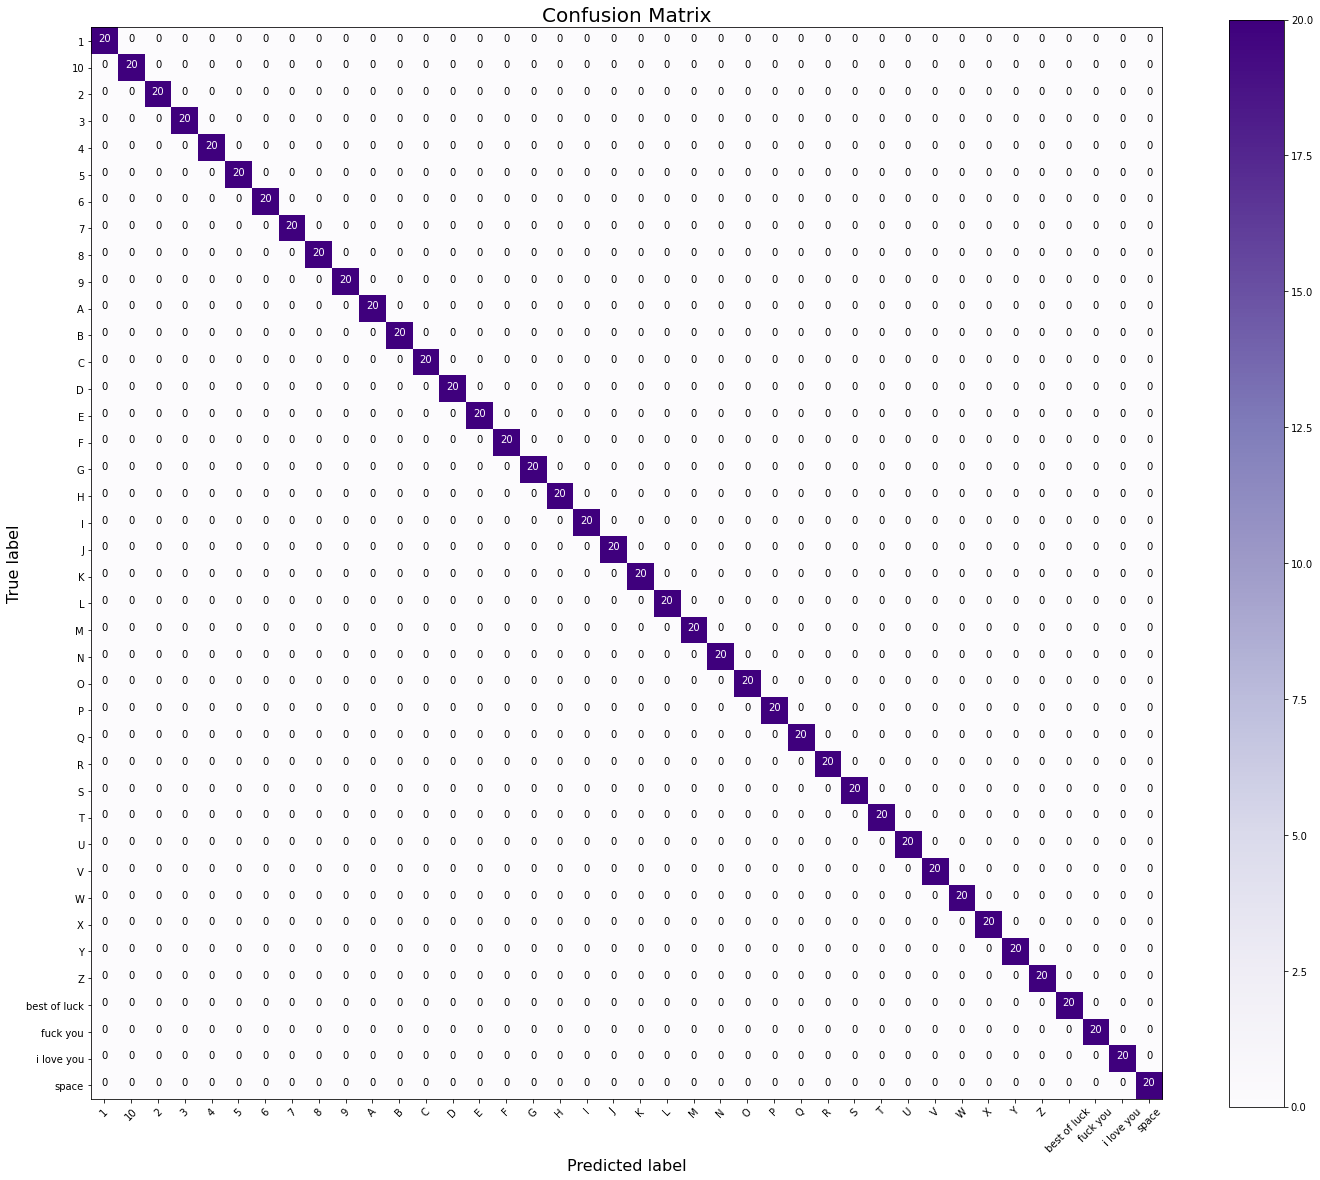

In [19]:
y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

10


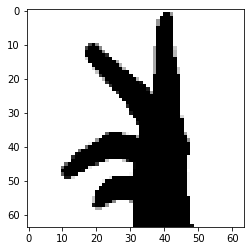

In [23]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/DataSetASD/training_set/10/10.png',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

if result[0][0] == 1:             
    prediction = '1'
elif result[0][1] == 1:
    prediction = '10'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
elif result[0][36] == 1:
    prediction = 'best of luck'
elif result[0][37] == 1:
    prediction = 'fuck you'
elif result[0][38] == 1:
    prediction = 'i love you'
else:
    prediction = '  '
    
print(prediction)